In [1]:
# Optimize Sigma Variation with ShareParameters

In [2]:
from desc import set_device
set_device("gpu")

In [3]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"
from scipy.io import netcdf_file
import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
import sys
import functools
import pickle

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put, fori_loop, jnp, sign

from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
from desc.objectives import *
from desc.objectives.objective_funs import _Objective
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison

from desc.plotting import *

from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile, PowerSeriesProfile

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, ToroidalMagneticField,
                                  field_line_integrate)

import desc.examples

from desc.backend import fori_loop, jit, jnp, odeint, sign
from desc.compute import rpz2xyz, rpz2xyz_vec, xyz2rpz, xyz2rpz_vec
from desc.coils import *

from desc.utils import Timer, copy_coeffs, errorif, setdefault, svd_inv_null, warnif
from desc.utils import flatten_list
#from ..utils import cross, dot, safediv, safenorm
#from desc.compute.utils import cross
#from desc.compute.utils import dot

from desc.optimize import lsqtr, lsq_auglag

from scipy.optimize import NonlinearConstraint 

from desc.magnetic_fields import ( SplineMagneticField, 
                                  #biot_savart_general, 
                                  FourierCurrentPotentialField, 
                                  ToroidalMagneticField,
                                  field_line_integrate)

import time

import numpy as np
from numpy.linalg import eig

from scipy.linalg import null_space
from numpy import ndarray


from desc.derivatives import Derivative

DESC version 0.12.3+553.gcb761a802.dirty,using JAX backend, jax version=0.4.35, jaxlib version=0.4.34, dtype=float64

Using device: NVIDIA A100-SXM4-80GB (id=0), with 80.00 GB available memory

In [4]:
#from desc.continuation import solve_continuation_automatic

from desc.objectives import (
    #AspectRatio,
    #FixBoundaryR,
    #FixBoundaryZ,
    #FixCurrent,
    #FixPressure,
    #FixPsi,
    #ForceBalance,
    ObjectiveFunction,
    #QuasisymmetryTwoTerm,
    #RotationalTransform,
    FixParameters, 
    ShareParameters,
    QuadraticFlux, 
    SurfaceCurrentRegularization, 
    bRegularization,
    PlasmaVesselDistance,
    MeanCurvature,
    PrincipalCurvature,
)
from desc.optimize import Optimizer

In [5]:
# Plasma surfaces
eqname_QA = "/home/fcastro/LMStell/regcoil/rogerio/input.QA_final_output.h5" #vacuum equilibrium
eq_QA = desc.io.load(eqname_QA)[4]

eqname_QH = "/home/fcastro/LMStell/regcoil/rogerio/input.QH_final_output.h5" #vacuum equilibrium
eq_QH = desc.io.load(eqname_QH)[4]

In [6]:
G_QA = eq_QA.compute("G")["G"][-1] / mu_0 * 2*np.pi
G_QH = eq_QH.compute("G")["G"][-1] / mu_0 * 2*np.pi

In [7]:
eq = eq_QA

R0 = 1.0
a = 0.3

surf = FourierRZToroidalSurface(R_lmn=[R0,a], 
                                Z_lmn=[-a],
                                modes_R=np.array([[0,0],[1,0]]),
                                modes_Z=np.array([[-1,0]]),
                                NFP=eq.NFP
                               )
surf.change_resolution(N=eq.N)

eq.axis.R_n = eq_QA.axis.R_n + 0.5*(eq_QH.axis.R_n - eq_QA.axis.R_n)
eq.axis.Z_n = eq_QA.axis.Z_n + 0.5*(eq_QH.axis.Z_n - eq_QA.axis.Z_n)

######
for coef, mode in zip(eq.axis.R_n, eq.axis.R_basis.modes):
    n = mode[-1]
    surf.R_lmn=surf.R_lmn.at[surf.R_basis.get_idx(M=0,N=n)].set( coef)
for coef, mode in zip(eq.axis.Z_n, eq.axis.Z_basis.modes):
    n = mode[-1]
    surf.Z_lmn=surf.Z_lmn.at[surf.Z_basis.get_idx(M=0,N=n)].set( coef)

In [8]:
surf1 = surf

surf1.change_resolution(M=12,N=12)

# Generate a Surface Current field for RQA
surf1 = FourierCurrentPotentialField.from_surface(surf1,M_Phi=12,N_Phi=12,sym_Phi=False, I=0, G=G_QA)

# Generate a Surface Current field for RQH
surf2 = surf1.copy()
surf2.G = G_QH

In [9]:
eq_QA.NFP

3

In [10]:
eq_QH.NFP

3

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

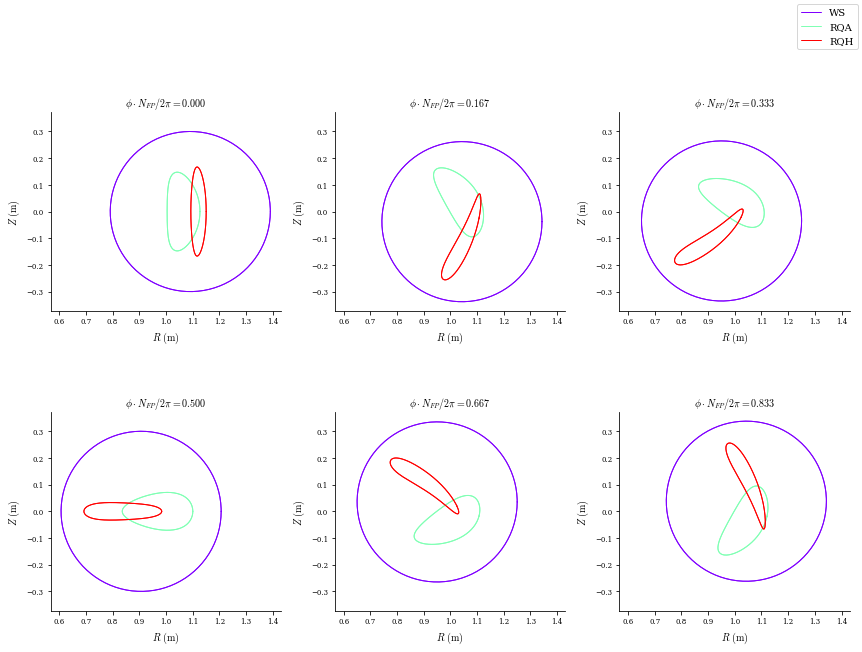

In [11]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [12]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal to eachother as they vary with surface current to reduce Bn
# first, keep surfs fixed too and just get regcoil-like solutions for each

In [13]:
# Grids
Megrid = 20
Negrid = 20

Msgrid = 20
Nsgrid = 20

egrid = LinearGrid(M=Megrid,N=Negrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False)

sgrid = LinearGrid(M=Msgrid,N=Nsgrid,
                   #NFP = 1,
                   NFP=eq.NFP,
                   sym=False) 

In [14]:
flux_QA = QuadraticFlux(eq_QA,surf1,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QA")

flux_QH = QuadraticFlux(eq_QH,surf2,field_grid=sgrid,
                        eval_grid=egrid,vacuum=True,
                        name="Bn error  eq_QH")

In [15]:
obj = ObjectiveFunction((flux_QA,
                         flux_QH,
                        )
                       )
constraints = (
    FixParameters(surf1,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
    FixParameters(surf2,{"I":True,"G":True,"R_lmn":True, "Z_lmn":True}),
) # fix the secular parts as well
                        
opt = Optimizer("lsq-exact")

(surf1, surf2), _ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=5,
                                 ftol = 0,#1e-8,
                                 gtol = 0,#1e-8,
                                 xtol = 0,#1e-8,
                                 options={"initial_trust_radius":np.inf})


Building objective: Bn error  eq_QA

Precomputing transforms

Timer: Precomputing transforms = 1.13 sec

Building objective: Bn error  eq_QH

Precomputing transforms

Timer: Precomputing transforms = 44.7 ms

Timer: Objective build = 1.56 sec

Building objective: fixed parameters

Building objective: fixed parameters

Timer: Objective build = 202 ms

Timer: Linear constraint projection build = 3.05 sec

Number of parameters: 1250

Number of objectives: 3362

Timer: Initializing the optimization = 4.90 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          3.073e+02                                    2.083e-03   

/home/fcastro/DESC/desc/optimize/least_squares.py:346: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= tr_old / trust_radius


       1              2          4.533e-08      3.073e+02      5.753e+05      1.390e-13   

       2              4          4.533e-08      7.741e-19      8.772e-06      1.378e-13   

       3              5          4.533e-08      1.327e-18      1.745e-05      1.353e-13   

       4              6          4.533e-08      2.633e-18      3.462e-05      1.304e-13   

       5              7          4.533e-08      5.351e-18      6.866e-05      1.209e-13   

         Current function value: 4.533e-08

         Total delta_x: 5.753e+05

         Iterations: 5

         Function evaluations: 7

         Jacobian evaluations: 6

Timer: Solution time = 17.5 sec

Timer: Avg time per step = 2.92 sec

                                                                 Start  -->   End

Total (sum of squares):                                      3.073e+02  -->   4.533e-08, 

Maximum absolute Boundary normal field error:                3.501e-02  -->   2.621e-08 (T m^2)

Minimum absolute Boundary normal field error:                3.129e-17  -->   3.648e-12 (T m^2)

Average absolute Boundary normal field error:                1.035e-02  -->   4.241e-09 (T m^2)

Maximum absolute Boundary normal field error:                3.169e-01  -->   2.373e-07 (normalized)

Minimum absolute Boundary normal field error:                2.832e-16  -->   3.301e-11 (normalized)

Average absolute Boundary normal field error:                9.372e-02  -->   3.839e-08 (normalized)

Maximum absolute Boundary normal field error:                7.879e-02  -->   2.256e-06 (T m^2)

Minimum absolute Boundary normal field error:                3.296e-17  -->   9.960e-17 (T m^2)

Average absolute Boundary normal field error:                2.717e-02  -->   3.080e-07 (T m^2)

Maximum absolute Boundary normal field error:                1.383e+00  -->   3.959e-05 (normalized)

Minimum absolute Boundary normal field error:                5.784e-16  -->   1.748e-15 (normalized)

Average absolute Boundary normal field error:                4.768e-01  -->   5.404e-06 (normalized)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

Fixed parameters error:                                      0.000e+00  -->   0.000e+00 (~)

In [16]:
surf1.NFP

3

Text(0.5, 1.0, 'Phi surf2')

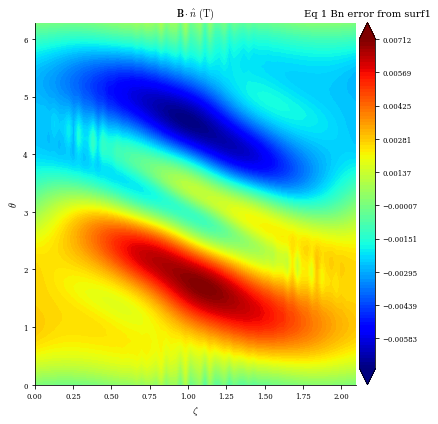

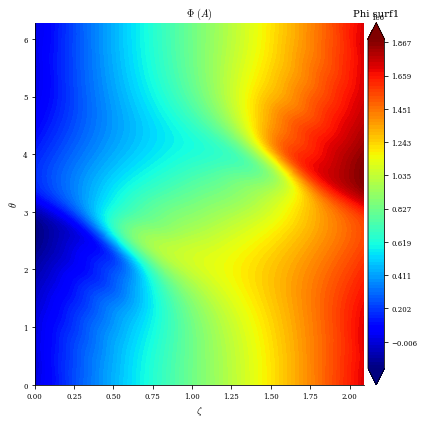

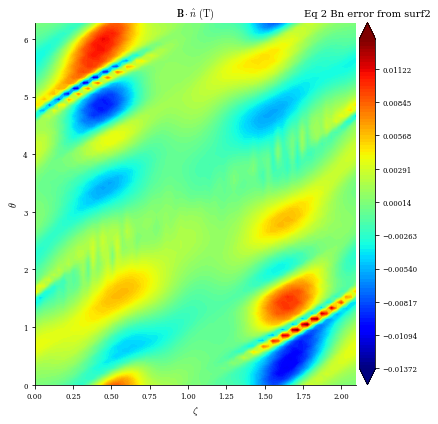

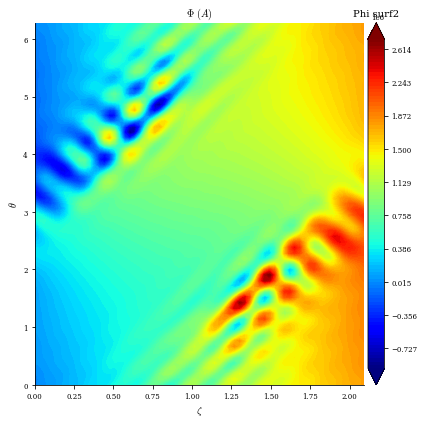

In [17]:
# look at Phi and Bn
denser_source_grid = LinearGrid(M=40,N=40,
                                #NFP=eq_QA.NFP
                               )
plot_2d(eq_QA,"B*n",field=surf1, field_grid=denser_source_grid)
plt.title("Eq 1 Bn error from surf1")

plot_2d(surf1, "Phi")
plt.title("Phi surf1")


plot_2d(eq_QH,"B*n",field=surf2, field_grid=denser_source_grid)
plt.title("Eq 2 Bn error from surf2")
plot_2d(surf2, "Phi")
plt.title("Phi surf2")

In [18]:
## setup opt problem
# use QuadraticFlux as eq's are fixed and want fields to change
# use ShareParameters to keep surface geoms constant equal
# to eachother as they vary with surface current to reduce Bn

In [19]:
# Distance target
min_QA = 0.1
max_QA = 0.25

min_QH = 0.12
max_QH = 0.25

# Distance to veseel penalization
obj_dist_QA = PlasmaVesselDistance(
    eq_QA,
    surf1,
    bounds=(min_QA,max_QA),
    #target = 0.15,
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    weight = 4.5,
    use_signed_distance=True,
    name="distance error  RQA"
)

obj_dist_QH = PlasmaVesselDistance(
    eq_QH,
    surf1,
    #target = 0.15,
    bounds=(min_QH,max_QH),
    plasma_grid=egrid,
    surface_grid=sgrid,
    eq_fixed=True,
    #softmin_alpha = 1e6,
    use_signed_distance=True,
    weight = 6.5,
    name="distance error  RQH"
)

In [20]:
mean_curv = -0.3
min_mean_curv = 0#-0.5
max_mean_curv = -0.15

obj_mean_curv = MeanCurvature(
    surf1,
    #target = mean_curv,
    bounds = (-15,-10),
    weight=1e0,
    normalize=True,
    normalize_target=True,
    deriv_mode="auto",
    grid=sgrid,
    name="Mean curvature",
)

In [21]:
obj_prin_curv = PrincipalCurvature(surf1,
        #target=None,
        bounds=(-np.inf,0),
        weight=5e-1,
        #normalize=True,
        #normalize_target=True,
        #loss_function=None,
        #deriv_mode="auto",
        grid=sgrid,
        name="principal-curvature",
        #jac_chunk_size=None,
    )

In [22]:
obj = ObjectiveFunction((#flux_QA,
                         #flux_QH,
                         obj_dist_QA,
                         obj_dist_QH,
                         #obj_mean_curv,
                         obj_prin_curv,
                         #surf_curr_reg_QA,
                         #surf_curr_reg_QH,
                         #obj_sigma_QA,
                         #obj_sigma_QH,
                        )
                       )
constraints = (
    #FixParameters(surf1,{"G":True,}),# fix the secular poloidal current
    #FixParameters(surf2,{"G":True,}),# fix the secular poloidal current
    # make the 2 surfaces have the same geometry, dont need bc geom is fixed here
    ShareParameters([surf1,surf2],params={"R_lmn":True, "Z_lmn":True}), 
)

In [23]:
# Choose the optimizer
opt = Optimizer("lsq-exact")

In [24]:
# Run optimization
(surf1, surf2),_ = opt.optimize([surf1, surf2], 
                                 objective=obj, 
                                 constraints=constraints,
                                 verbose=3,
                                 maxiter=80,
                                ftol=0,
                                gtol=0,
                                xtol=0,
                                 options={"initial_trust_radius":np.inf})

Building objective: distance error  RQA

Precomputing transforms

Timer: Precomputing transforms = 123 ms

Building objective: distance error  RQH

Precomputing transforms

Timer: Precomputing transforms = 30.9 ms

Building objective: principal-curvature

Precomputing transforms

Timer: Precomputing transforms = 36.9 ms

Timer: Objective build = 253 ms

Building objective: shared parameters

Timer: Objective build = 4.81 ms

Timer: Linear constraint projection build = 2.28 sec

Number of parameters: 1879

Number of objectives: 5043

Timer: Initializing the optimization = 2.61 sec


Starting optimization

Using method: lsq-exact

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   

       0              1          1.963e+03                                    9.443e+03   

       1              3          1.054e+03      9.086e+02      4.504e-02      2.656e+03   

       2              4          9.774e+02      7.696e+01      2.390e-02      9.364e+03   

       3              5          8.791e+02      9.835e+01      6.809e-03      4.966e+03   

       4              6          8.465e+02      3.257e+01      3.358e-03      2.097e+03   

       5              7          8.308e+02      1.572e+01      5.515e-03      4.859e+03   

       6              8          7.973e+02      3.344e+01      2.901e-03      1.471e+03   

       7             10          7.763e+02      2.101e+01      3.175e-03      1.363e+03   

       8             11          7.543e+02      2.203e+01      6.217e-03      4.374e+03   

       9             12          7.312e+02      2.308e+01      2.892e-03      2.720e+03   

      10             13          7.212e+02      1.004e+01      2.820e-03      3.547e+03   

      11             14          7.110e+02      1.014e+01      2.665e-03      3.244e+03   

      12             15          7.032e+02      7.803e+00      2.708e-03      3.093e+03   

      13             16          6.970e+02      6.224e+00      2.719e-03      4.519e+03   

      14             17          6.860e+02      1.098e+01      6.278e-04      2.348e+03   

      15             18          6.780e+02      7.973e+00      1.499e-03      2.156e+03   

      16             19          6.739e+02      4.150e+00      1.521e-03      2.863e+03   

      17             20          6.684e+02      5.431e+00      1.333e-03      3.123e+03   

      18             21          6.648e+02      3.677e+00      1.364e-03      3.417e+03   

      19             22          6.603e+02      4.469e+00      1.244e-03      3.320e+03   

      20             23          6.569e+02      3.363e+00      1.303e-03      3.315e+03   

      21             24          6.530e+02      3.982e+00      1.213e-03      3.286e+03   

      22             25          6.499e+02      3.092e+00      1.299e-03      3.634e+03   

      23             26          6.463e+02      3.599e+00      1.195e-03      3.631e+03   

      24             27          6.435e+02      2.799e+00      1.254e-03      3.757e+03   

      25             28          6.402e+02      3.292e+00      1.197e-03      3.586e+03   

      26             29          6.377e+02      2.462e+00      1.245e-03      3.692e+03   

      27             30          6.333e+02      4.396e+00      2.964e-04      1.994e+03   

      28             31          6.304e+02      2.947e+00      6.743e-04      2.020e+03   

      29             32          6.284e+02      1.969e+00      7.398e-04      1.915e+03   

      30             33          6.259e+02      2.522e+00      6.867e-04      1.984e+03   

      31             34          6.241e+02      1.751e+00      6.898e-04      2.077e+03   

      32             35          6.218e+02      2.317e+00      6.712e-04      2.610e+03   

      33             36          6.202e+02      1.602e+00      6.810e-04      2.236e+03   

      34             37          6.181e+02      2.070e+00      6.547e-04      2.308e+03   

      35             38          6.167e+02      1.430e+00      6.805e-04      2.186e+03   

      36             39          6.151e+02      1.580e+00      1.648e-04      1.583e+03   

      37             40          6.136e+02      1.515e+00      3.641e-04      1.696e+03   

      38             41          6.123e+02      1.275e+00      3.866e-04      1.500e+03   

      39             42          6.114e+02      9.046e-01      3.651e-04      2.099e+03   

      40             43          6.102e+02      1.282e+00      3.566e-04      1.439e+03   

      41             44          6.091e+02      1.078e+00      3.625e-04      1.936e+03   

      42             45          6.081e+02      9.713e-01      3.563e-04      1.628e+03   

      43             46          6.070e+02      1.060e+00      3.451e-04      1.945e+03   

      44             47          6.061e+02      9.283e-01      3.486e-04      1.772e+03   

      45             48          6.050e+02      1.150e+00      3.431e-04      2.044e+03   

      46             49          6.041e+02      8.886e-01      3.536e-04      1.696e+03   

      47             50          6.029e+02      1.148e+00      3.554e-04      2.060e+03   

      48             51          6.021e+02      8.678e-01      3.594e-04      1.702e+03   

      49             52          6.010e+02      1.020e+00      3.405e-04      2.243e+03   

      50             53          6.003e+02      7.469e-01      3.326e-04      1.661e+03   

      51             54          5.993e+02      9.568e-01      3.267e-04      2.130e+03   

      52             55          5.986e+02      7.607e-01      3.301e-04      1.765e+03   

      53             56          5.976e+02      9.926e-01      3.373e-04      2.020e+03   

      54             57          5.969e+02      6.753e-01      3.306e-04      1.762e+03   

      55             58          5.960e+02      9.387e-01      3.295e-04      2.559e+03   

      56             59          5.952e+02      7.628e-01      3.503e-04      2.217e+03   

      57             60          5.943e+02      9.140e-01      3.398e-04      2.416e+03   

      58             61          5.936e+02      6.849e-01      3.365e-04      2.119e+03   

      59             62          5.928e+02      7.863e-01      3.268e-04      2.402e+03   

      60             63          5.921e+02      7.062e-01      3.244e-04      1.939e+03   

      61             64          5.913e+02      8.037e-01      3.170e-04      2.066e+03   

      62             65          5.907e+02      6.154e-01      3.088e-04      2.006e+03   

      63             66          5.901e+02      6.217e-01      7.859e-05      1.428e+03   

      64             67          5.894e+02      6.353e-01      1.870e-04      1.459e+03   

      65             68          5.888e+02      6.140e-01      1.975e-04      1.511e+03   

      66             69          5.884e+02      4.333e-01      1.942e-04      1.419e+03   

      67             70          5.878e+02      6.035e-01      1.830e-04      1.400e+03   

      68             71          5.874e+02      3.966e-01      1.858e-04      1.527e+03   

      69             72          5.869e+02      5.042e-01      1.751e-04      1.317e+03   

      70             73          5.864e+02      4.615e-01      1.945e-04      1.465e+03   

      71             74          5.860e+02      4.447e-01      1.796e-04      1.507e+03   

      72             75          5.855e+02      4.793e-01      1.861e-04      1.449e+03   

      73             76          5.850e+02      4.979e-01      1.797e-04      1.555e+03   

      74             77          5.846e+02      4.211e-01      1.833e-04      1.924e+03   

      75             78          5.841e+02      4.860e-01      1.807e-04      1.702e+03   

      76             79          5.838e+02      3.451e-01      1.801e-04      1.509e+03   

      77             80          5.833e+02      4.996e-01      1.721e-04      1.523e+03   

      78             81          5.829e+02      3.607e-01      1.794e-04      1.365e+03   

      79             82          5.824e+02      5.082e-01      1.774e-04      1.744e+03   

      80             83          5.821e+02      3.125e-01      1.737e-04      1.482e+03   

         Current function value: 5.821e+02

         Total delta_x: 8.571e-02

         Iterations: 80

         Function evaluations: 83

         Jacobian evaluations: 81

Timer: Solution time = 46.7 sec

Timer: Avg time per step = 577 ms

                                                                 Start  -->   End

Total (sum of squares):                                      1.963e+03  -->   5.821e+02, 

Maximum Plasma-vessel distance:                              3.257e-01  -->   3.225e-01 (m)

Minimum Plasma-vessel distance:                              8.101e-02  -->   6.553e-02 (m)

Average Plasma-vessel distance:                              2.011e-01  -->   1.950e-01 (m)

Maximum Plasma-vessel distance:                              3.169e+00  -->   3.138e+00 (normalized)

Minimum Plasma-vessel distance:                              7.883e-01  -->   6.377e-01 (normalized)

Average Plasma-vessel distance:                              1.957e+00  -->   1.898e+00 (normalized)

Maximum Plasma-vessel distance:                              3.097e-01  -->   2.618e-01 (m)

Minimum Plasma-vessel distance:                              6.063e-02  -->   6.271e-02 (m)

Average Plasma-vessel distance:                              1.994e-01  -->   1.989e-01 (m)

Maximum Plasma-vessel distance:                              3.235e+00  -->   2.734e+00 (normalized)

Minimum Plasma-vessel distance:                              6.333e-01  -->   6.550e-01 (normalized)

Average Plasma-vessel distance:                              2.083e+00  -->   2.077e+00 (normalized)

Maximum Principal curvature:                                 3.690e+00  -->   6.221e+00 (m^-1)

Minimum Principal curvature:                                 3.092e+00  -->   6.684e-01 (m^-1)

Average Principal curvature:                                 3.377e+00  -->   3.375e+00 (m^-1)

Maximum Principal curvature:                                 1.107e+00  -->   1.866e+00 (normalized)

Minimum Principal curvature:                                 9.275e-01  -->   2.005e-01 (normalized)

Average Principal curvature:                                 1.013e+00  -->   1.012e+00 (normalized)

Shared parameters error:                                     0.000e+00  -->   1.159e-13 (~)

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

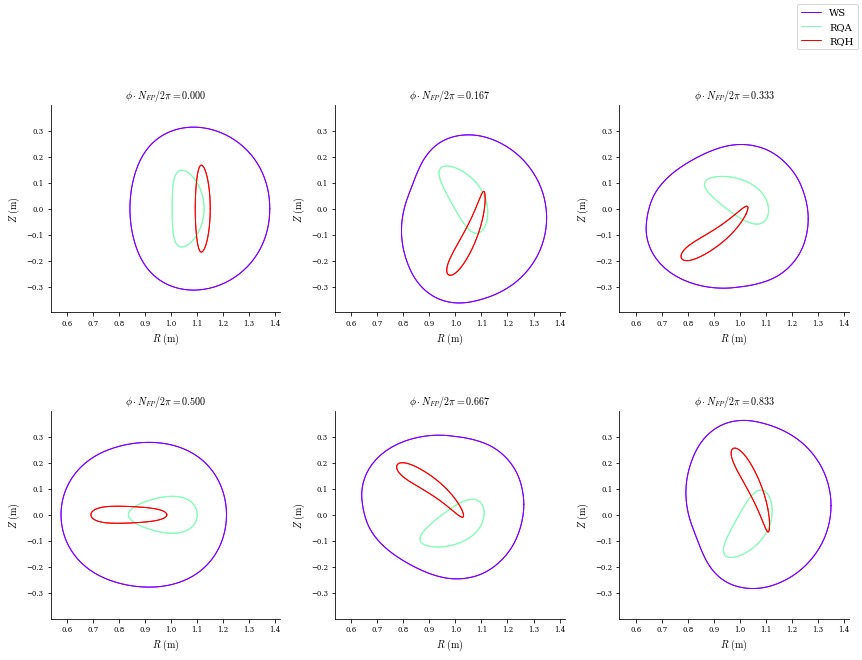

In [25]:
plot_comparison([surf1,eq_QA,eq_QH],
                labels=["WS","RQA","RQH"],
                theta=0,rho=np.array(1.0)
               )

In [26]:
surf1.save("surf_opt.h5")

(<Figure size 864x720 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

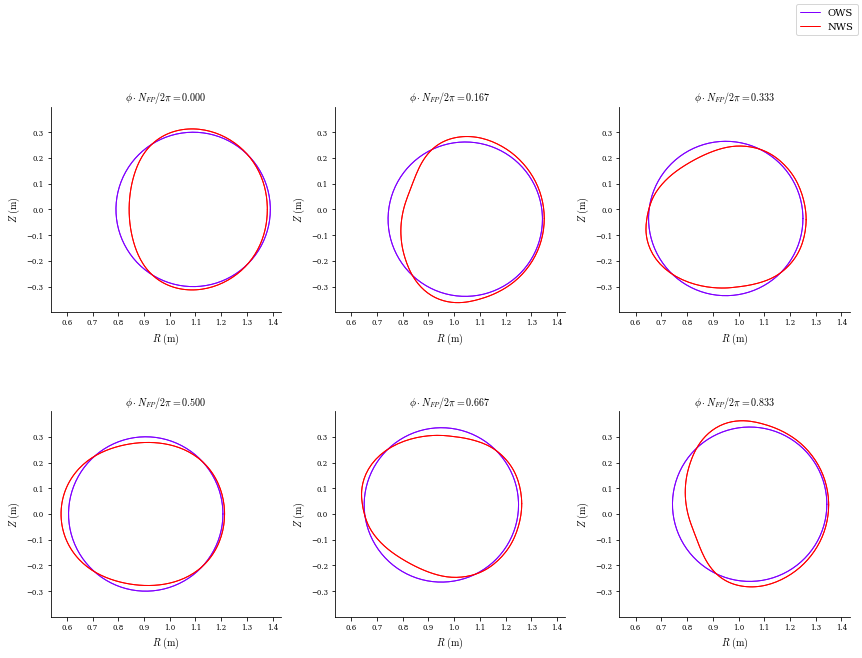

In [27]:
plot_comparison([surf,surf1],
                labels=["OWS","NWS"],
                theta=0,rho=np.array(1.0)
               )